# Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

## Initial Model

In [2]:
card_df = pd.read_csv('./files/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [4]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('Training Dataset')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('\nTest Dataset')
print(y_test.value_counts()/y_test.shape[0] * 100)

Training Dataset
0    99.827451
1     0.172549
Name: Class, dtype: float64

Test Dataset
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred) 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    print('\nAccuracy: {0:.4f} \nPrecision: {1:.4f} \nRecall: {2:.4f} \nF1: {3:.4f} \nAUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[85283    12]
 [   59    89]]

Accuracy: 0.9992 
Precision: 0.8812 
Recall: 0.6014 
F1: 0.7149 
AUC:0.9592


In [8]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Confusion Matrix
[[85290     5]
 [   36   112]]

Accuracy: 0.9995 
Precision: 0.9573 
Recall: 0.7568 
F1: 0.8453 
AUC:0.9790


## Scaling feature

<AxesSubplot:xlabel='Amount', ylabel='Density'>

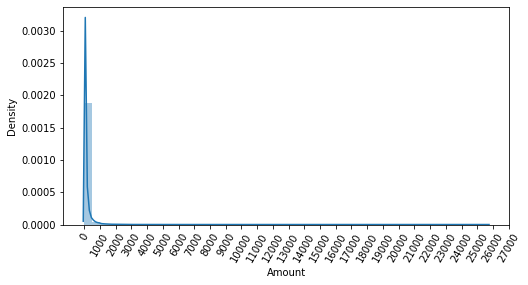

In [10]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [11]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [12]:
print('Logistic Regression Evaluation\n')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Logistic Regression Evaluation

Confusion Matrix
[[85281    14]
 [   58    90]]

Accuracy: 0.9992 
Precision: 0.8654 
Recall: 0.6081 
F1: 0.7143 
AUC:0.9702


In [13]:
print('LightGBM Evaluation\n')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM Evaluation

Confusion Matrix
[[85290     5]
 [   37   111]]

Accuracy: 0.9995 
Precision: 0.9569 
Recall: 0.7500 
F1: 0.8409 
AUC:0.9779


## Converting feature into log form

In [14]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [15]:
print('Logistic Regression Evaluation\n')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Logistic Regression Evaluation

Confusion Matrix
[[85283    12]
 [   59    89]]

Accuracy: 0.9992 
Precision: 0.8812 
Recall: 0.6014 
F1: 0.7149 
AUC:0.9727


In [16]:
print('LightGBM Evaluation\n')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM Evaluation

Confusion Matrix
[[85290     5]
 [   35   113]]

Accuracy: 0.9995 
Precision: 0.9576 
Recall: 0.7635 
F1: 0.8496 
AUC:0.9796


## Removing Outliers

<AxesSubplot:>

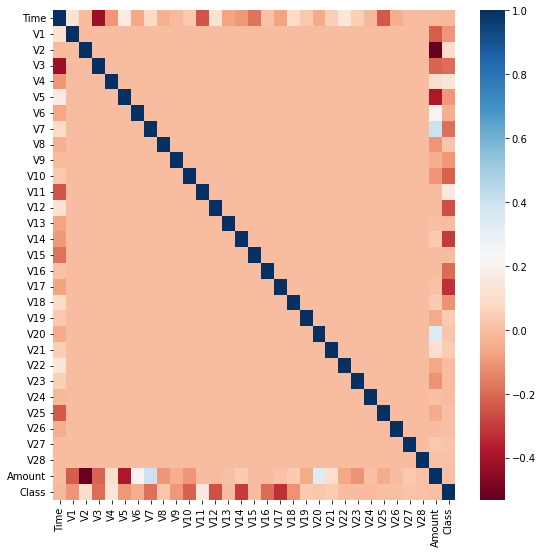

In [17]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [18]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [19]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('Outlier:', outlier_index)

Outlier: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [20]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [21]:
print('Logistic Regression Evaluation\n')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Logistic Regression Evaluation

Confusion Matrix
[[85281    14]
 [   48    98]]

Accuracy: 0.9993 
Precision: 0.8750 
Recall: 0.6712 
F1: 0.7597 
AUC:0.9743


In [22]:
print('LightGBM Evaluation\n')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM Evaluation

Confusion Matrix
[[85290     5]
 [   25   121]]

Accuracy: 0.9996 
Precision: 0.9603 
Recall: 0.8288 
F1: 0.8897 
AUC:0.9780


## Applying SMOTE

In [23]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('before SMOTE:', X_train.shape, y_train.shape)
print(pd.Series(y_train).value_counts())
print('\nafter SMOTE:', X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

before SMOTE: (199362, 29) (199362,)
0    199020
1       342
Name: Class, dtype: int64

after SMOTE: (398040, 29) (398040,)
0    199020
1    199020
Name: Class, dtype: int64


In [24]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

Confusion Matrix
[[82937  2358]
 [   11   135]]

Accuracy: 0.9723 
Precision: 0.0542 
Recall: 0.9247 
F1: 0.1023 
AUC:0.9737


In [25]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

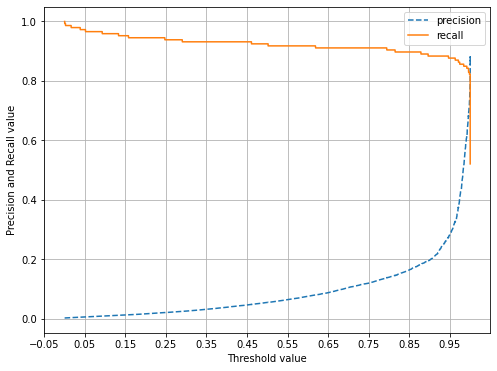

In [26]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [27]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

Confusion Matrix
[[85283    12]
 [   22   124]]

Accuracy: 0.9996 
Precision: 0.9118 
Recall: 0.8493 
F1: 0.8794 
AUC:0.9814
